In [ ]:
import os
import sys
import time
import json
import numpy as np
import torch
import joblib
from pathlib import Path
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from multi_traj_predict.data.trajectory_loader import load_dataset
from multi_traj_predict.models.attention_bi_gru_predictor import TrajPredictor
from multi_traj_predict.utils.logger import get_logger, log_metrics_for_features
from multi_traj_predict.utils.plot_generator import (
    plot_trajectories,
    plot_3d_trajectories_subplots,
)
from multi_traj_predict.utils.scaler import scale_per_agent

# Change to project root
os.chdir("..")  # go up one level from notebooks/
sys.path.append(".")


In [ ]:
# pylint: disable=all
# Data settings and parameters
DATA_TYPE = "zurich"  # Options: "zurich", "quadcopter", "mixed", "simulated"
SEQUENTIAL_PREDICTION = (
    True  # If False, model predicts only the last point for FORWARD_LEN steps
)
EMBEDDING_EXTRACTION = False
AGENTS = 6  # Number of agents or drones
LOOK_BACK = 50  # Number of past time steps to use as input

if EMBEDDING_EXTRACTION:
    FORWARD_LEN = 50  # Prediction is the same as LOOK_BACK for embedding extraction
else:
    FORWARD_LEN = 5  # Number of future time steps to predict

if DATA_TYPE == "simulated":
    FEATURES_PER_AGENT = 6  # x, y, z, vx, vy, vz, ax, ay, az
else:
    FEATURES_PER_AGENT = 3 # x, y, z

# Training parameters
BATCH_SIZE = 32
EPOCHS = 500
LEARNING_RATE = 1e-3

# Plotting parameters
NUM_PLOTS = 2  # number of plots to generate
NUM_SUBPLOTS = 2  # number of subplots to generate

In [3]:
# Setup logger and experiment folder
logger, exp_dir = get_logger()
os.makedirs(exp_dir, exist_ok=True)

logger.info("Experiment started")
logger.info("Experiment folder: %s", exp_dir)
logger.info("Dataset: %s", DATA_TYPE)
logger.info("Number of drones (agents): %d", AGENTS)
logger.info("LOOK_BACK (past steps): %d", LOOK_BACK)
logger.info("FORWARD_LEN (future steps): %d", FORWARD_LEN)
logger.info("SEQUENTIAL_PREDICTION: %s", "True" if SEQUENTIAL_PREDICTION else "False")

2025-11-25 17:07:19,297 - INFO - Experiment started
2025-11-25 17:07:19,298 - INFO - Experiment folder: experiments/20251125_170719
2025-11-25 17:07:19,298 - INFO - Dataset: zurich
2025-11-25 17:07:19,298 - INFO - Number of drones (agents): 6
2025-11-25 17:07:19,299 - INFO - LOOK_BACK (past steps): 50
2025-11-25 17:07:19,300 - INFO - FORWARD_LEN (future steps): 50
2025-11-25 17:07:19,301 - INFO - SEQUENTIAL_PREDICTION: True


In [4]:
# Load DataFrame
df = load_dataset(
    DATA_TYPE,
    min_rows=800,
    num_flights=AGENTS,
    features_per_agent=FEATURES_PER_AGENT,
)
print(df.shape)

# Prepare sequences
# Track trajectory indices to be used in plotting later
X, y, trajectory_ids = [], [], []

for traj_idx in df["trajectory_index"].unique():
    traj_df = df[df["trajectory_index"] == traj_idx].reset_index(drop=True)

    # Drop trajectory_index for features
    traj_data = traj_df.drop(columns=["trajectory_index"]).values.astype(np.float32)
    n_rows = traj_data.shape[0]

    seq_count = n_rows - LOOK_BACK - FORWARD_LEN + 1
    for i in range(seq_count):
        seq_X = traj_data[i : i + LOOK_BACK]  # shape (LOOK_BACK, features)

        # For sequential prediction, predict FORWARD_LEN steps; else just the last step
        if EMBEDDING_EXTRACTION is False:
            if SEQUENTIAL_PREDICTION:
                seq_y = traj_data[
                    i + LOOK_BACK : i + LOOK_BACK + FORWARD_LEN
                ]  # shape (FORWARD_LEN, features)
            else:
                seq_y = traj_data[
                    i + LOOK_BACK + FORWARD_LEN - 1 : i + LOOK_BACK + FORWARD_LEN
                ]  # (1, features)
        else:
            seq_y = seq_X.copy()  # For embedding extraction, target is same as input

        X.append(seq_X)
        y.append(seq_y)
        trajectory_ids.append(traj_idx)

(22400, 19)


In [5]:
# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)  # (num_sequences, LOOK_BACK, features)
y = np.array(
    y, dtype=np.float32
)  # (num_sequences, 1, features) or (num_sequences, FORWARD_LEN, features)
trajectory_ids = np.array(trajectory_ids)

# Split train/test
X_train, X_test, y_train, y_test, traj_train, traj_test = train_test_split(
    X, y, trajectory_ids, test_size=0.2, shuffle=False
)

# Get feature dimension dynamically
num_features_X = X_train.shape[-1]

# Scale data to [0, 1]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on training data only
X_train_scaled = scale_per_agent(X_train, scaler_X, FEATURES_PER_AGENT, fit=True)
X_test_scaled = scale_per_agent(X_test, scaler_X, FEATURES_PER_AGENT, fit=False)

y_train_scaled = scale_per_agent(y_train, scaler_y, FEATURES_PER_AGENT, fit=True)
y_test_scaled = scale_per_agent(y_test, scaler_y, FEATURES_PER_AGENT, fit=False)

# Save scalers
joblib.dump(scaler_X, os.path.join(exp_dir, "scaler_X.pkl"))
joblib.dump(scaler_y, os.path.join(exp_dir, "scaler_y.pkl"))

# Convert to tensors
X_train_tensor = torch.tensor(
    X_train_scaled, dtype=torch.float32
)  # (num_sequences, LOOK_BACK, features)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create DataLoaders
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False
)

In [6]:
# Log dataset sizes
total_sequences = X_train_tensor.shape[0] + X_test_tensor.shape[0]
logger.info("Total sequences: %d", total_sequences)
logger.info("Train sequences: %s", X_train_tensor.shape)
logger.info("Test sequences: %s", X_test_tensor.shape)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info("Using device: %s", device)

2025-11-25 17:07:20,057 - INFO - Total sequences: 19628
2025-11-25 17:07:20,058 - INFO - Train sequences: torch.Size([15702, 50, 18])
2025-11-25 17:07:20,059 - INFO - Test sequences: torch.Size([3926, 50, 18])
2025-11-25 17:07:20,061 - INFO - Using device: cpu


In [7]:
# Model, criterion, optimizer
model_params = {
    "input_size": FEATURES_PER_AGENT,
    "enc_hidden_size": 64,
    "dec_hidden_size": 64,
    "num_layers": 1,
}
model = TrajPredictor(**model_params).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Log model info
logger.info("Model module: %s", model.__class__.__module__)
logger.info("Model architecture:\n%s", model)

2025-11-25 17:07:20,867 - INFO - Model module: multi_traj_predict.models.attention_bi_gru_predictor
2025-11-25 17:07:20,868 - INFO - Model architecture:
TrajPredictor(
  (encoder): GRU(3, 64, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=192, out_features=64, bias=True)
    (v): Linear(in_features=64, out_features=1, bias=False)
  )
  (enc_to_dec): Linear(in_features=128, out_features=64, bias=True)
  (decoder): GRU(131, 64, batch_first=True)
  (fc_out): Linear(in_features=64, out_features=3, bias=True)
)


In [8]:
# Log training time
training_start = time.time()

# Early stopping parameters
patience = 10
best_loss = float("inf")
epochs_no_improve = 0
early_stop = False

# Training Loop
model.train()
try:
    for epoch in range(EPOCHS):
        total_loss = 0.0
        for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}"):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()

            # Add prediction_len argument if sequential prediction
            if SEQUENTIAL_PREDICTION:
                pred = model(batch_x, pred_len=FORWARD_LEN)
            else:
                pred = model(batch_x, pred_len=1)

            loss = criterion(pred, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        logger.info("Epoch %d/%d - Train Loss: %.7f", epoch + 1, EPOCHS, avg_loss)

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), os.path.join(exp_dir, "best_model.pt"))
        else:
            epochs_no_improve += 1

        # If no improvement for 'patience' epochs, stop training
        if epochs_no_improve >= patience:
            logger.info("Early stopping triggered after %d epochs", epoch + 1)
            early_stop = True
            break

except KeyboardInterrupt:
    logger.warning("Training interrupted by user! Running evaluation...")

# Save last-epoch model
finally:
    torch.save(model.state_dict(), os.path.join(exp_dir, "last_model.pt"))

# If training completed without early stopping
if not early_stop:
    logger.info("Training finished without early stopping.")

# Log total training time
training_end_time = time.time()
elapsed_time = training_end_time - training_start
logger.info("Total training time: %.2f seconds", elapsed_time)

Epoch 1/500: 100%|██████████| 491/491 [07:12<00:00,  1.14it/s]
2025-11-25 17:14:33,013 - INFO - Epoch 1/500 - Train Loss: 0.0053952
Epoch 2/500:  50%|█████     | 247/491 [03:34<03:32,  1.15it/s]
2025-11-25 17:18:07,776 - WARNING - Training interrupted by user! Running evaluation...
2025-11-25 17:18:07,780 - INFO - Training finished without early stopping.
2025-11-25 17:18:07,781 - INFO - Total training time: 646.91 seconds


In [9]:
# Evaluation parameters
all_preds, all_trues = [], []
inference_times = []
test_loss = 0.0
total_sequences = 0

model.eval()
with torch.no_grad():
    for batch_x, batch_y in tqdm(test_loader, desc="Evaluating"):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        total_sequences += batch_x.size(0)

        # Measure inference time
        start_time = time.time()

        # Add prediction_len argument if sequential prediction
        if SEQUENTIAL_PREDICTION:
            outputs = model(batch_x, pred_len=FORWARD_LEN)
        else:
            outputs = model(batch_x, pred_len=1)

        end_time = time.time()

        # Record inference time per batch
        inference_times.append(end_time - start_time)

        # Compute test loss
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        # Store predictions and true values
        all_preds.append(outputs.cpu())
        all_trues.append(batch_y.cpu())

# Compute average test loss
avg_test_loss = test_loss / len(test_loader)

# Compute total inference time, average inference time per batch and per sequence
total_inf_time = sum(inference_times)
avg_inf_time_per_seq = total_inf_time / total_sequences
avg_inf_time_per_batch = total_inf_time / len(test_loader)

# Log final test metrics
logger.info("Test Loss (scaled): %.7f", avg_test_loss)
logger.info("Average inference time per sequence: %.6f seconds", avg_inf_time_per_seq)
logger.info("Average inference time per batch: %.6f seconds", avg_inf_time_per_batch)

Evaluating: 100%|██████████| 123/123 [00:59<00:00,  2.05it/s]
2025-11-25 17:19:09,883 - INFO - Test Loss (scaled): 0.0000892
2025-11-25 17:19:09,883 - INFO - Average inference time per sequence: 0.015213 seconds
2025-11-25 17:19:09,884 - INFO - Average inference time per batch: 0.485578 seconds


In [10]:
# Concatenate all batches
y_pred = torch.cat(all_preds, dim=0)
y_true = torch.cat(all_trues, dim=0)

log_metrics_for_features(y_true, y_pred, scaler_y, AGENTS, FEATURES_PER_AGENT, logger)

2025-11-25 17:19:32,918 - INFO - -----------------------------------------------------------------------------------------------------------------------------------------------------------
2025-11-25 17:19:32,919 - INFO - Timestep |        EDE |        MSE |       RMSE |        MAE |      MSE_x     MSE_y     MSE_z     RMSE_x    RMSE_y    RMSE_z      MAE_x     MAE_y     MAE_z
2025-11-25 17:19:32,920 - INFO - -----------------------------------------------------------------------------------------------------------------------------------------------------------
2025-11-25 17:19:32,920 - INFO -        0 |   4.464035 |   9.034128 |   3.005683 |   2.060757 |   7.886719  18.291040   0.924599 |   2.808330   4.276803   0.961561 |   2.340007   3.140492   0.701760
2025-11-25 17:19:32,920 - INFO -        1 |   3.397852 |   7.070898 |   2.659116 |   1.680660 |   7.961959  12.174375   1.076342 |   2.821694   3.489180   1.037469 |   1.889298   2.397871   0.754807
2025-11-25 17:19:32,921 - INFO -   

In [11]:
# Save config / hyperparameters
config = {
    "device": str(device),
    "model_module": model.__class__.__module__,
    "model_class": model.__class__.__name__,
    "model_params": model_params,
    "DATA_TYPE": DATA_TYPE,
    "AGENTS": AGENTS,
    "FEATURES_PER_AGENT": FEATURES_PER_AGENT,
    "LOOK_BACK": LOOK_BACK,
    "FORWARD_LEN": FORWARD_LEN,
    "SEQUENTIAL_PREDICTION": SEQUENTIAL_PREDICTION,
    "EPOCHS": EPOCHS,
    "BATCH_SIZE": BATCH_SIZE,
    "LEARNING_RATE": LEARNING_RATE,
}

config_path = os.path.join(exp_dir, "config.json")
with open(config_path, "w", encoding="utf-8") as f:
    json.dump(config, f, indent=4)

logger.info("Config saved to %s", config_path)

2025-11-25 17:23:53,515 - INFO - Config saved to experiments/20251125_170719/config.json


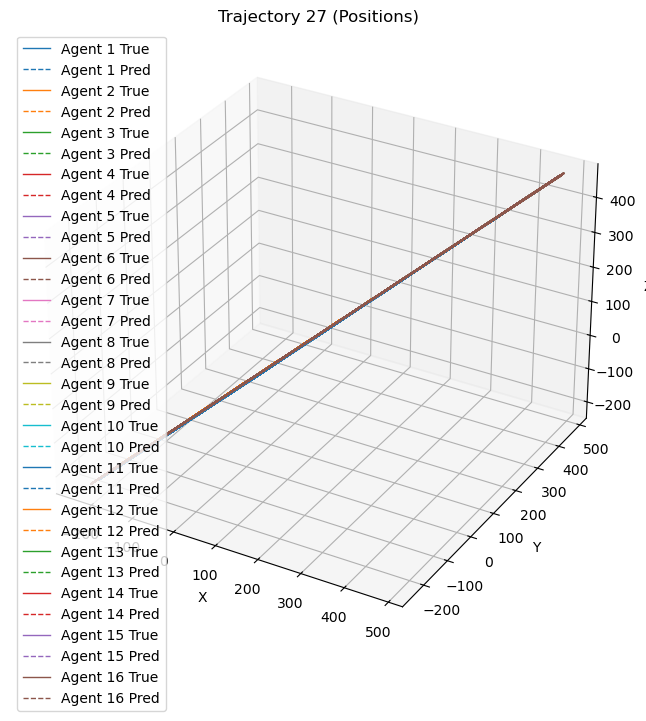

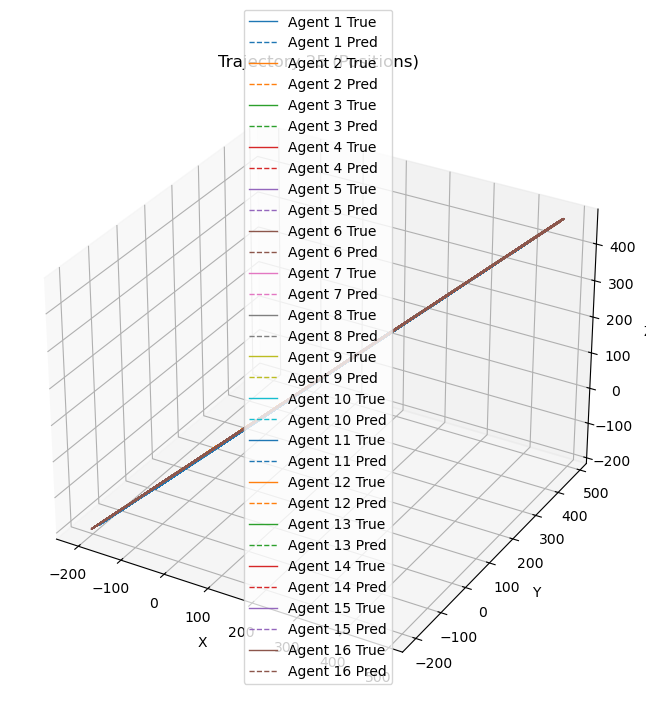

In [ ]:
if FEATURES_PER_AGENT == 3:
    # Group results back by trajectory_index
    traj_test = traj_test[: len(y_true)]  # align just in case
    unique_trajs = np.unique(traj_test)

    # Randomly select trajectories to plot
    plot_trajs = np.random.choice(
        unique_trajs, size=min(NUM_PLOTS, len(unique_trajs)), replace=False
    ).tolist()

    # Plot trajectories using the helper function
    plot_trajectories(
        y_true=y_true.numpy(),
        y_pred=y_pred.numpy(),
        traj_ids=traj_test,
        plot_trajs=plot_trajs,
        scaler=scaler_y,
        agents=AGENTS,
        save_dir=exp_dir,
    )

In [ ]:
if FEATURES_PER_AGENT == 3:
    # Stack all past inputs (for context)
    past_inputs = torch.cat(
        [b for b, _ in test_loader], dim=0
    ).numpy()  # (num_sequences, LOOK_BACK, num_features)

    # Ensure NUM_PLOTS does not exceed number of sequences
    num_sequences = y_true.shape[0]
    NUM_SUBPLOTS = min(NUM_SUBPLOTS, num_sequences)

    # Randomly select sequence indices for plotting
    plot_indices = np.random.choice(num_sequences, size=NUM_SUBPLOTS, replace=False)

    trajectory_sets = []

    for seq_idx in plot_indices:
        past = past_inputs[seq_idx]  # shape: (LOOK_BACK, features)
        true_future = y_true[seq_idx]  # shape: (seq_len, features)
        pred_future = y_pred[seq_idx]  # shape: (seq_len, features)

        # Inverse scale past and future
        past_orig = scale_per_agent(past, scaler_X, FEATURES_PER_AGENT, inverse=True)
        true_future_orig = scale_per_agent(
            true_future, scaler_y, FEATURES_PER_AGENT, inverse=True
        )
        pred_future_orig = scale_per_agent(
            pred_future, scaler_y, FEATURES_PER_AGENT, inverse=True
        )

        # Concatenate last past point with future to make continuous lines
        true_line = np.vstack([past_orig[-1:], true_future_orig])
        pred_line = np.vstack([past_orig[-1:], pred_future_orig])

        trajectory_sets.append((past_orig, true_line, pred_line))

    # Create subplots for selected sequences
    plot_path = Path(exp_dir) / "training_subplots.png"
    plot_3d_trajectories_subplots(
        trajectory_sets,
        per_agent=True,
        save_path=str(plot_path),
    )